In [3]:
from dataclasses import dataclass, field
from typing import List, Optional, Dict
from collections import defaultdict, Counter


@dataclass
class MarketData:

    """ Data model for market observations """
    crash_headline: bool
    market_direction: str

    def __post_init__(self):
        if self.market_direction not in ['Up', 'Down']:
            raise ValueError("market_direction must be 'Up' or 'Down'")


@dataclass
class BayesianParameters:
    """ Data model for Bayesian parameters """
    priors: Dict[str, float]
    likelihoods: Dict[str, Dict[str, float]]
    evidence: Dict[bool, float]

    def __post_init__(self):
        self.priors = self.priors or {}
        self.likelihoods = defaultdict(dict, self.likelihoods or {})
        self.evidence = self.evidence or {}


@dataclass
class PredictionResult:
    """ Data model for prediction results """
    posteriors: Dict[str, float]
    most_likely_direction: str
    confidence: float
    input_condition: bool

    @property
    def confidence_percentage(self) -> float:
        """ Returns confidence as a percentage """
        return self.confidence * 100

In [2]:


class DataLoader:
    """ Class to load and validate data for market predictions """

    def __init__(self):
        self.data: list[MarketData] = []

    def load_sample_data(self) -> list[MarketData]:
        """ Load sample market data for testing """
        sample_data = [
            (True, 'Down'),   # Day 1: Yes crash, Down
            (False, 'Up'),    # Day 2: No crash, Up
            (True, 'Down'),   # Day 3: Yes crash, Down
            (False, 'Up'),    # Day 4: No crash, Up
            (True, 'Down'),   # Day 5: Yes crash, Down
            (True, 'Down'),   # Day 6: Yes crash, Down
            (False, 'Up'),    # Day 7: No crash, Up
            (False, 'Down'),  # Day 8: No crash, Down
            (True, 'Down'),   # Day 9: Yes crash, Down
            (False, 'Up'),    # Day 10: No crash, Up
        ]
        return [MarketData(crash, direction) for crash, direction in sample_data]


    def add_data_point(self, crash_headline: bool, market_direction: str) -> None:
        """ Add a single data point to the dataset """
        new_data = MarketData(crash_headline, market_direction)
        self.data.append(new_data)

    def get_data(self) -> list[MarketData]:
        """ Retrieve the current dataset """
        return self.data.copy()

In [4]:

class ProbabilityCalculator:
    """Responsible for calculating Bayesian probabilities"""

    @staticmethod
    def calculate_priors(data: list[MarketData]) -> Dict[str, float]:
        """Calculate prior probabilities P(Market Direction)"""
        if not data:
            return {}

        directions = [d.market_direction for d in data]
        direction_counts = Counter(directions)
        total = len(data)

        return {direction: count / total for direction, count in direction_counts.items()}

    @staticmethod
    def calculate_likelihoods(data: list[MarketData]) -> Dict[str, Dict[bool, float]]:
        """Calculate likelihood probabilities P(Feature | Market Direction)"""
        if not data:
            return defaultdict(dict)

        likelihoods = defaultdict(dict)

        direction_groups = defaultdict(list)
        for d in data:
            direction_groups[d.market_direction].append(d)

        for direction, group_data in direction_groups.items():
            total_for_direction = len(group_data)
            crash_count = sum(1 for d in group_data if d.crash_headline)

            likelihoods[direction][True] = crash_count / total_for_direction
            likelihoods[direction][False] = (total_for_direction - crash_count) / total_for_direction

        return dict(likelihoods)

    @staticmethod
    def calculate_evidence(data: list[MarketData]) -> Dict[bool, float]:
        """Calculate evidence probabilities P(Feature)"""
        if not data:
            return {}

        total = len(data)
        crash_count = sum(1 for d in data if d.crash_headline)

        return {
            True: crash_count / total,
            False: (total - crash_count) / total
        }

    @staticmethod
    def apply_bayes_theorem(priors: Dict[str, float], likelihoods: Dict[str, Dict[bool, float]], evidence: Dict[bool, float], observed_feature: bool) -> Dict[str, float]:
        """Apply Bayes' theorem to calculate posterior probabilities"""
        posteriors = {}

        for direction in priors.keys():
            if evidence[observed_feature] == 0:
                posteriors[direction] = 0
            else:
                numerator = likelihoods[direction][observed_feature] * priors[direction]
                posteriors[direction] = numerator / evidence[observed_feature]

        return posteriors

In [5]:
class ModelTrainer:
    """Responsible for training the Bayesian model"""

    def __init__(self, calculator: ProbabilityCalculator):
        self.calculator = calculator

    def train(self, data: list[MarketData]) -> BayesianParameters:
        """Train the model and return parameters"""
        if not data:
            raise ValueError("Cannot train on empty dataset")

        priors = self.calculator.calculate_priors(data)
        likelihoods = self.calculator.calculate_likelihoods(data)
        evidence = self.calculator.calculate_evidence(data)

        return BayesianParameters(priors, likelihoods, evidence)

In [6]:
class MarketPredictor:
    """Responsible for making predictions using trained model"""

    def __init__(self, calculator: ProbabilityCalculator):
        self.calculator = calculator
        self.parameters: Optional[BayesianParameters] = None

    def set_parameters(self, parameters: BayesianParameters):
        """Set the trained model parameters"""
        self.parameters = parameters

    def predict(self, crash_headline: bool) -> PredictionResult:
        """Make a prediction for given input"""
        if not self.parameters:
            raise ValueError("Model not trained! Set parameters first.")

        posteriors = self.calculator.apply_bayes_theorem(
            self.parameters.priors,
            self.parameters.likelihoods,
            self.parameters.evidence,
            crash_headline
        )

        # Find most likely outcome
        most_likely_direction = max(posteriors.items(), key=lambda x: x[1])

        return PredictionResult(
            posteriors=posteriors,
            most_likely_direction=most_likely_direction[0],
            confidence=most_likely_direction[1],
            input_condition=crash_headline
        )

In [7]:
class StatisticsReporter:
    """Responsible for reporting training and prediction statistics"""

    @staticmethod
    def report_training_stats(data: list[MarketData], parameters: BayesianParameters):
        """Print comprehensive training statistics"""
        print(f"\n📊 Dataset Summary:")
        print(f"Total days: {len(data)}")
        crash_days = sum(1 for d in data if d.crash_headline)
        print(f"Days with 'crash' headlines: {crash_days}")
        print(f"Days without 'crash' headlines: {len(data) - crash_days}")

        print(f"\n📈 Market Direction Distribution:")
        for direction, prob in parameters.priors.items():
            print(f"P(Market {direction}) = {prob:.3f}")

        print(f"\n🔍 Likelihoods:")
        for direction in parameters.priors.keys():
            print(f"P(Crash=True | Market {direction}) = {parameters.likelihoods[direction][True]:.3f}")
            print(f"P(Crash=False | Market {direction}) = {parameters.likelihoods[direction][False]:.3f}")

    @staticmethod
    def report_prediction(result: PredictionResult):
        """Print detailed prediction results"""
        crash_text = "contains 'crash'" if result.input_condition else "does NOT contain 'crash'"
        print(f"\n🔮 Prediction for headlines that {crash_text}:")
        print("=" * 50)

        for direction, probability in result.posteriors.items():
            print(f"P(Market {direction} | Crash={result.input_condition}) = {probability:.3f} ({probability*100:.1f}%)")

        print(f"\n🎯 Most likely outcome: Market will go {result.most_likely_direction.upper()}")
        print(f"   Confidence: {result.confidence:.1f}%")

In [8]:
class UserInterface:
    """Responsible for user interaction"""

    def __init__(self, predictor: MarketPredictor, reporter: StatisticsReporter):
        self.predictor = predictor
        self.reporter = reporter

    def run_interactive_mode(self):
        """Run interactive prediction mode"""
        print("\n" + "="*60)
        print("INTERACTIVE MODE")
        print("="*60)

        while True:
            user_input = input("\nDoes today's headline contain 'crash'? (yes/no/quit): ").lower().strip()

            if user_input in ['quit', 'q', 'exit']:
                print("Goodbye! 👋")
                break
            elif user_input in ['yes', 'y', '1']:
                result = self.predictor.predict(crash_headline=True)
                self.reporter.report_prediction(result)
            elif user_input in ['no', 'n', '0']:
                result = self.predictor.predict(crash_headline=False)
                self.reporter.report_prediction(result)
            else:
                print("Please enter 'yes', 'no', or 'quit'")

    def demonstrate_predictions(self):
        """Demonstrate predictions for both scenarios"""
        print("\n" + "="*60)
        print("MAKING PREDICTIONS")
        print("="*60)

        # Scenario 1: Headlines contain "crash"
        result1 = self.predictor.predict(crash_headline=True)
        self.reporter.report_prediction(result1)

        # Scenario 2: Headlines do NOT contain "crash"
        result2 = self.predictor.predict(crash_headline=False)
        self.reporter.report_prediction(result2)

In [9]:
class BayesianMarketApplication:
    """Main application orchestrator following SRP"""

    def __init__(self):
        self.data_loader = DataLoader()
        self.calculator = ProbabilityCalculator()
        self.trainer = ModelTrainer(self.calculator)
        self.predictor = MarketPredictor(self.calculator)
        self.reporter = StatisticsReporter()
        self.ui = UserInterface(self.predictor, self.reporter)

    def run(self):
        """Run the complete application"""
        print("🏦 Bayesian Market Prediction System")
        print("=" * 40)

        # Load and train
        data = self.data_loader.load_sample_data()
        parameters = self.trainer.train(data)
        self.predictor.set_parameters(parameters)

        # Report training results
        print("Training completed!")
        self.reporter.report_training_stats(data, parameters)

        # Demonstrate predictions
        self.ui.demonstrate_predictions()

        # Interactive mode
        self.ui.run_interactive_mode()


# Entry point
if __name__ == "__main__":
    app = BayesianMarketApplication()
    app.run()

🏦 Bayesian Market Prediction System
Training completed!

📊 Dataset Summary:
Total days: 10
Days with 'crash' headlines: 5
Days without 'crash' headlines: 5

📈 Market Direction Distribution:
P(Market Down) = 0.600
P(Market Up) = 0.400

🔍 Likelihoods:
P(Crash=True | Market Down) = 0.833
P(Crash=False | Market Down) = 0.167
P(Crash=True | Market Up) = 0.000
P(Crash=False | Market Up) = 1.000

MAKING PREDICTIONS

🔮 Prediction for headlines that contains 'crash':
P(Market Down | Crash=True) = 1.000 (100.0%)
P(Market Up | Crash=True) = 0.000 (0.0%)

🎯 Most likely outcome: Market will go DOWN
   Confidence: 1.0%

🔮 Prediction for headlines that does NOT contain 'crash':
P(Market Down | Crash=False) = 0.200 (20.0%)
P(Market Up | Crash=False) = 0.800 (80.0%)

🎯 Most likely outcome: Market will go UP
   Confidence: 0.8%

INTERACTIVE MODE

Does today's headline contain 'crash'? (yes/no/quit): yes

🔮 Prediction for headlines that contains 'crash':
P(Market Down | Crash=True) = 1.000 (100.0%)
P(Mar

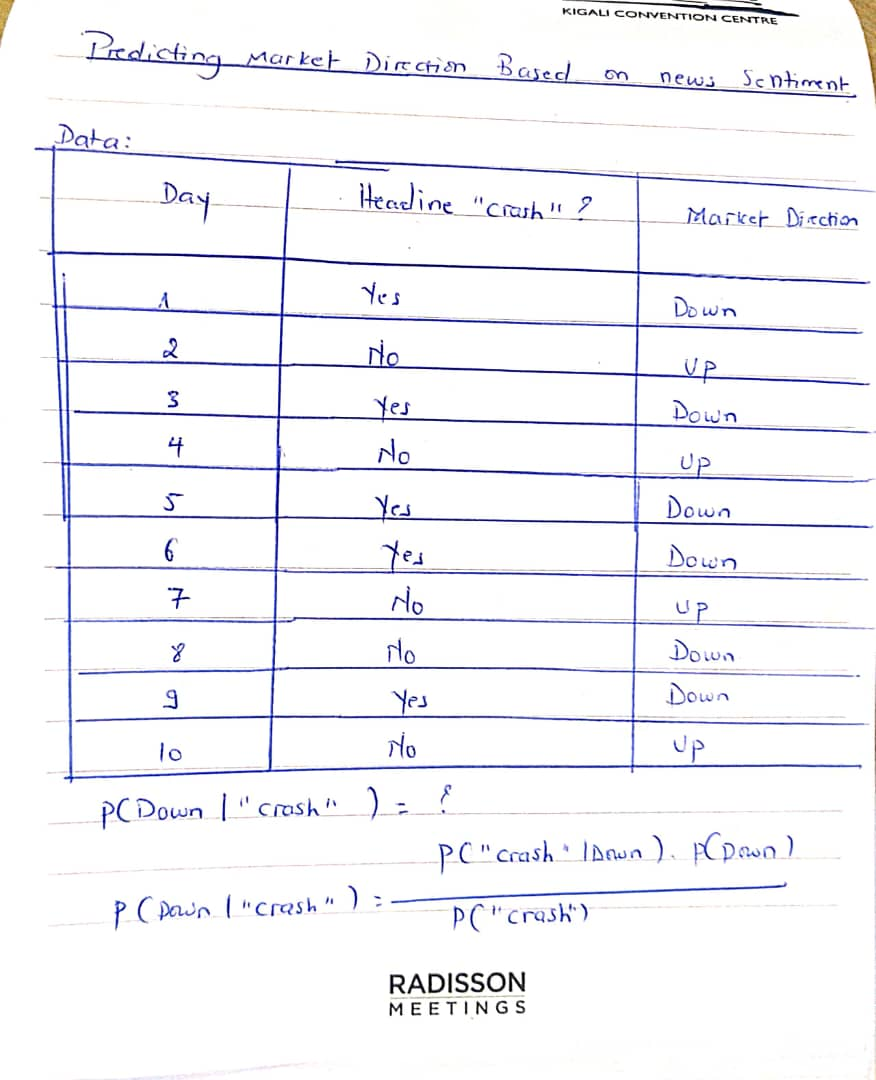

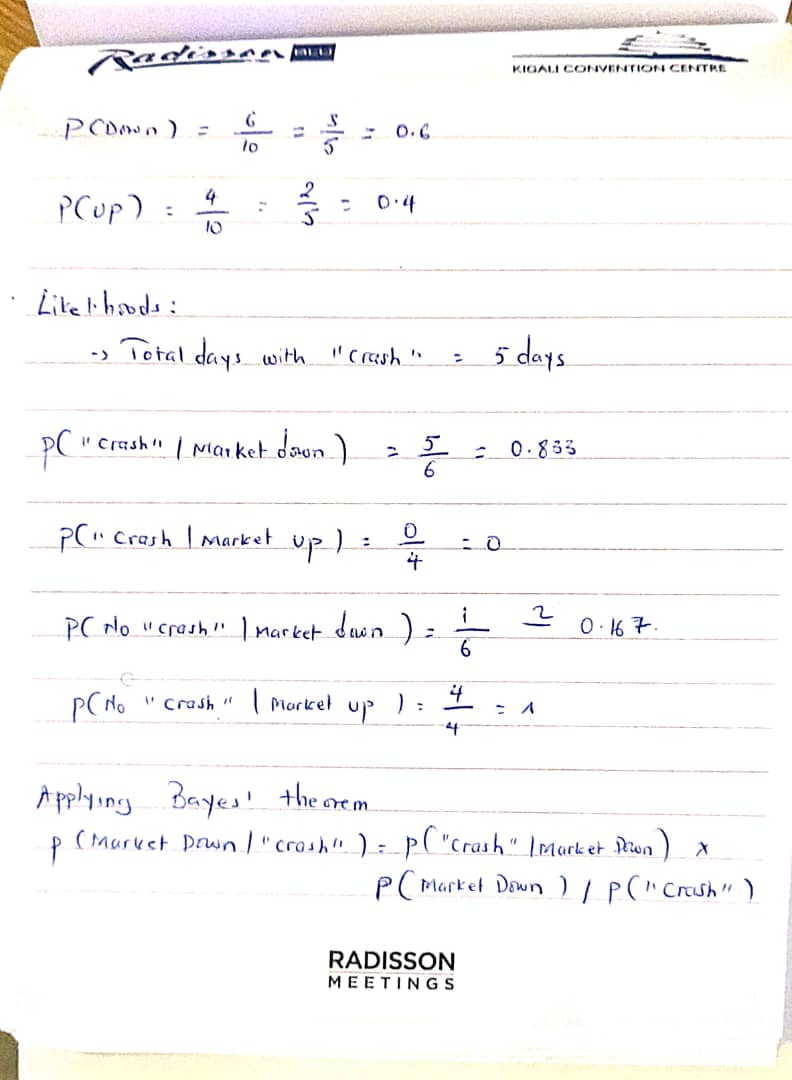

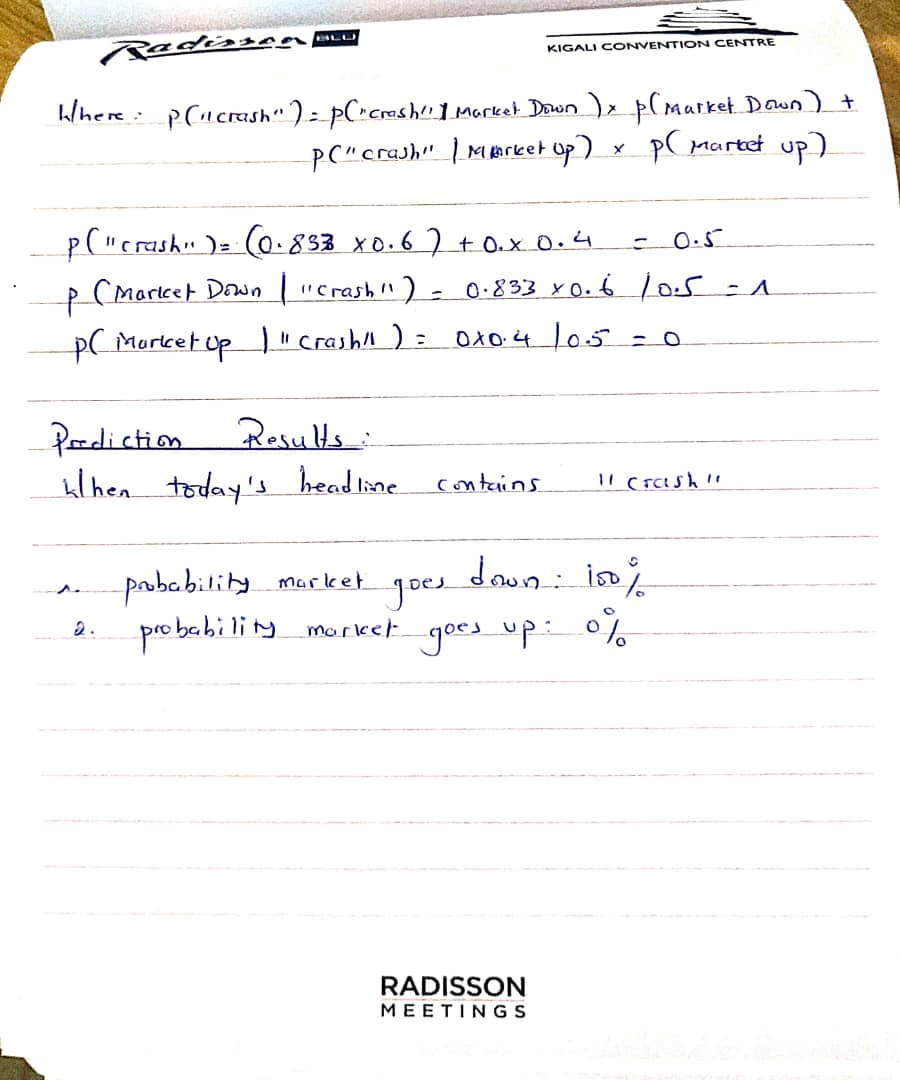